![title](DEP_LOGO_2.jpg)

# Trend Station Water Quality Data 
## Web Application Demo

In [100]:
#HIDDEN

import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import pandas as pd
import csv
from geopy.geocoders import Nominatim
from time import sleep
import folium
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from folium.plugins import MarkerCluster
import seaborn as sns
from scipy import stats
from scipy.stats import linregress
from arcgis.gis import GIS
import geopandas as gpd

pd.set_option('display.max_columns', 50)

## Explore Available Trend Stations:

[Link to New WVDEP Trend Station Map](https://bonnerjf33.maps.arcgis.com/apps/webappviewer/index.html?id=dc634873ef5e4275b7120482e93a080c)

In [101]:
#HIDDEN

#Filter Warnings!
import warnings
warnings.filterwarnings("ignore")

# Display the associated webpage in a new window
import IPython
url = 'https://bonnerjf33.maps.arcgis.com/apps/webappviewer/index.html?id=dc634873ef5e4275b7120482e93a080c'
iframe = '<iframe src=' + url + ' width=990 height=1000 frameborder=1></iframe>'
IPython.display.HTML(iframe)

## Select Trend Station:

In [102]:
#HIDDEN

def unique_sorted_values(array):
    unique = array.unique().tolist()
    unique.sort()
    return unique

df_comb = pd.read_csv('TS_New_Combined_Final.csv')
df_comb = df_comb.fillna(0)

dfhead = pd.read_csv('gm_export_TS_Location.csv')
dfhead = dfhead.fillna(0)
dfheadloc = dfhead[dfhead.latitude != 0]

output_two = widgets.Output()
output_three = widgets.Output()
output_four = widgets.Output()
output_five = widgets.Output()
output_six = widgets.Output()
plot1_output = widgets.Output()
plot_output = widgets.Output()

dropdown_stations = widgets.Dropdown(options = unique_sorted_values(df_comb.station_id), description='Trend Station')

def common_filtering1(station):
    
    output_two.clear_output()
    output_three.clear_output()
    output_four.clear_output()
    output_five.clear_output()
    output_six.clear_output()
    #plot_output.clear_output()-OUTPUT USED ELSEWHERE!!!
    
    df_comb = pd.read_csv('TS_New_Combined_Final.csv')
    df_comb = df_comb.fillna(0)
    
    common_filter1 = df_comb[(df_comb.station_id == station)]
    
    global ts
    ts = dropdown_stations.value
    
    df_comb = df_comb[df_comb['station_id'].str.contains(str(ts), na=False)]
        
    group = df_comb.groupby('param_name')
    df2 = pd.DataFrame(group.apply(lambda x: x['test_batch_id'].unique()))

    df2.reset_index(inplace=True)
    df2 = df2.rename({0: 'DATES'}, axis='columns')

    dates = df2[df2.param_name == 'LAB CONDUCTIVITY'].DATES.item()

    initial_date = dates[0]
    
    df_comb_date = common_filter1
    df_comb_date = df_comb_date[df_comb_date['test_batch_id'] == initial_date]
    df_comb_date = df_comb_date.drop(['station_id', 'sample_id', 'result_unit', 'test_batch_id'], axis=1)
    df_comb_date = df_comb_date.set_index('param_name').transpose()

    #df_comb_date = df_comb_date.astype('float')-THIS WAS NOT WORKING!!!! UNNECESSARY!!!
    #df_comb_date.columns = ['FIELD ph', 'FIELD CONDUCTIVITY','TEMPERATURE','FLOW', 'LAB CONDUCTIVITY', 'SULFATE', 'DISSOLVED SOLIDS', 'SUSPENDED SOLIDS', 'LAB ph', 'ALKALINITY', 'HOT ACIDITY', 'MINERAL ACIDITY', 'IRON_D', 'MANGANESE_D', 'ALUMINUM_D', 'IRON_T', 'MANGANESE_T', 'ALUMINUM_T', 'ANTIMONY', 'ARSENIC', 'BERYLLIUM', 'CADMIUM', 'CHROMIUM', 'COPPER', 'LEAD', 'MERCURY', 'NICKEL', 'SELENIUM', 'SILVER', 'THALLIUM', 'ZINC', 'CYANIDE', 'PHENOLS', 'NITRATE', 'SODIUM', 'CALCIUM', 'MAGNESIUM', 'POTASSIUM', 'BI-CARBONATE', 'CARBONATE', 'PHOSPHATE']

    global df_comb_concat
    df_comb_concat = []
    df_comb_concat = pd.concat([df_comb_date], axis=0, sort=False)

    as_list = df_comb_concat.index.tolist()
    idx = as_list.index('result_value')
    as_list[idx] = initial_date
    df_comb_concat.index = as_list

    for i, date in enumerate(dates):
    
        df_comb_date = common_filter1
        df_comb_date = df_comb_date[df_comb_date['test_batch_id'] == dates[i]]
        df_comb_date = df_comb_date.drop(['station_id', 'sample_id', 'result_unit', 'test_batch_id'], axis=1)
        df_comb_date = df_comb_date.set_index('param_name').transpose()
    
        #df_comb_date = df_comb_date.astype('float')-THIS WAS NOT WORKING!!!! UNNECESSARY!!!

        #df_comb_date.columns = ['FIELD ph', 'FIELD CONDUCTIVITY','TEMPERATURE','FLOW', 'LAB CONDUCTIVITY', 'SULFATE', 'DISSOLVED SOLIDS', 'SUSPENDED SOLIDS', 'LAB ph', 'ALKALINITY', 'HOT ACIDITY', 'MINERAL ACIDITY', 'IRON_D', 'MANGANESE_D', 'ALUMINUM_D', 'IRON_T', 'MANGANESE_T', 'ALUMINUM_T', 'ANTIMONY', 'ARSENIC', 'BERYLLIUM', 'CADMIUM', 'CHROMIUM', 'COPPER', 'LEAD', 'MERCURY', 'NICKEL', 'SELENIUM', 'SILVER', 'THALLIUM', 'ZINC', 'CYANIDE', 'PHENOLS', 'NITRATE', 'SODIUM', 'CALCIUM', 'MAGNESIUM', 'POTASSIUM', 'BI-CARBONATE', 'CARBONATE', 'PHOSPHATE']
    
        df_comb_concat = pd.concat([df_comb_concat, df_comb_date], axis=0, sort=False)
    
        as_list = df_comb_concat.index.tolist()
        idx = as_list.index('result_value')
        as_list[idx] = dates[i]
        df_comb_concat.index = as_list

        df_comb_concat.index.name = str(dropdown_stations.value)
        
    #df_comb_concat = df_comb_concat.fillna(0)
    
    #df_comb_concat = df_comb_concat.loc[:, (df_comb_date != 0).any(axis=0)]-THIS WAS DELETING COLUMNS WITH ANY ZERO VALUES!!!

    df_comb_concat.index = pd.to_datetime(df_comb_concat.index)

    df_comb_concat = df_comb_concat.iloc[1:]
    
    global df_comb_concat_old
    df_comb_concat_old = pd.read_csv('TS_Old_Final/' + ts + '_Old_Combined_Final.csv')
    df_comb_concat_old.set_index(str(ts), inplace=True)
    df_comb_concat_old.index = pd.to_datetime(df_comb_concat_old.index)
    
    df_comb_concat = pd.concat([df_comb_concat_old, df_comb_concat], axis=0, sort=False)
      
    global dfdesc
    dfdesc = df_comb_concat.describe()
    dfdesc.index.name = str(ts)

    global dfcorr
    dfcorr = df_comb_concat.corr()
    dfcorr = dfcorr.dropna(axis=0, how='all') #Resolves problem from above step
    dfcorr = dfcorr.dropna(axis=1, how='all') #Resolves problem from above step
    dfcorr.index.name = str(ts)
    
    global common_filter
    common_filter = dfheadloc[(dfheadloc.station_id == station)]    
    
    with output_two:
        display(common_filter)
    
    with output_three:
        display(common_filter1)
        
    with output_four:
        display(df_comb_concat)
    
    with output_five:
        display(dfdesc)
        
    with output_six:
        display(dfcorr)
              
def dropdown_stations_eventhandler(change):
    common_filtering1(change.new)
    
dropdown_stations.observe(dropdown_stations_eventhandler, names='value')  
  
display(dropdown_stations)

Dropdown(description='Trend Station', options=('TS001', 'TS002', 'TS003', 'TS004', 'TS005', 'TS006', 'TS007', …

## Selected Trend Station Location Information:

In [103]:
#HIDDEN

display(output_two)

Output()

## Water Quality Data for Selected Trend Station:

In [104]:
#HIDDEN

display(output_four)

Output()

## Water Quality Statistics for Selected Trend Station Data:

In [105]:
#HIDDEN

display(output_five)

Output()

## Plot Water Quality Time-Series Data from Selected Trend Station:

Dropdown(description='Parameter 1', options=('ALKALINITY', 'ALUMINUM_D', 'ALUMINUM_T', 'ANTIMONY', 'ARSENIC', …

Dropdown(description='Parameter 2', options=('NONE', 'ALKALINITY', 'ALUMINUM_D', 'ALUMINUM_T', 'ANTIMONY', 'AR…

Button(description='Display/Update Plot', style=ButtonStyle())

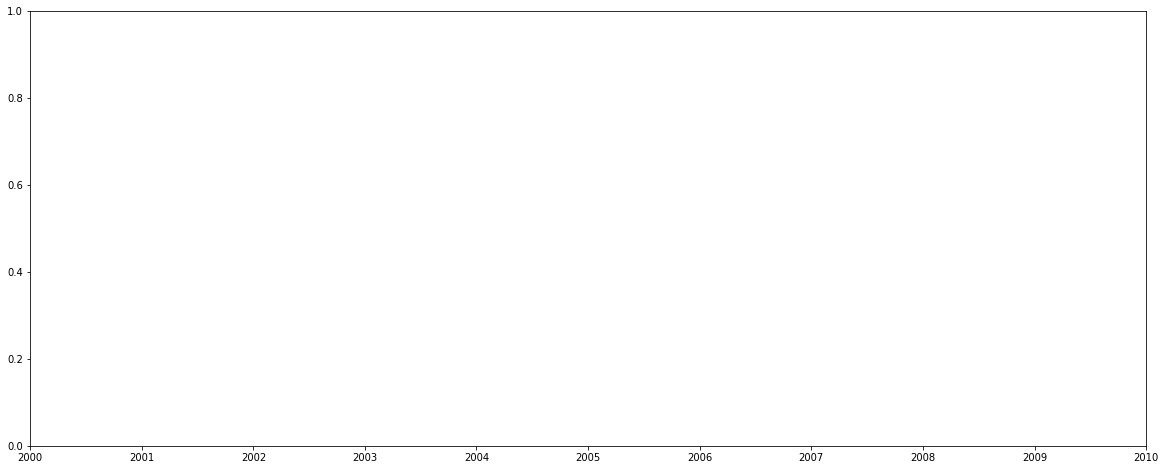

In [106]:
#HIDDEN

def unique_sorted_values_plus_none(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, 'NONE')
    return unique

labels=pd.Series(['FIELD ph', 'FIELD CONDUCTIVITY','TEMPERATURE','FLOW', 'LAB CONDUCTIVITY', 'SULFATE', 'DISSOLVED SOLIDS', 'SUSPENDED SOLIDS', 'LAB ph', 'ALKALINITY', 'HOT ACIDITY', 'MINERAL ACIDITY', 'IRON_D', 'MANGANESE_D', 'ALUMINUM_D', 'IRON_T', 'MANGANESE_T', 'ALUMINUM_T', 'ANTIMONY', 'ARSENIC', 'BERYLLIUM', 'CADMIUM', 'CHROMIUM', 'COPPER', 'LEAD', 'MERCURY', 'NICKEL', 'SELENIUM', 'SILVER', 'THALLIUM', 'ZINC', 'CYANIDE', 'PHENOLS', 'NITRATE', 'SODIUM', 'CALCIUM', 'MAGNESIUM', 'POTASSIUM', 'BI-CARBONATE', 'CARBONATE', 'PHOSPHATE'])

dropdown_param = widgets.Dropdown(options = unique_sorted_values(labels), description='Parameter 1')
dropdown_param3 = widgets.Dropdown(options = unique_sorted_values_plus_none(labels), description='Parameter 2')
button1 = widgets.Button(description='Display/Update Plot')

plot1_output = widgets.Output()

def on_button_click(param, param3):
        plot1_output.clear_output()
        with plot1_output:
            if param not in df_comb_concat.columns:
                print('NO DATA EXISTS FOR THE CHOSEN STATION/PARAMETER COMBINATION! PLEASE SELECT ANOTHER PARAMETER.')
    
            elif param3 == 'NONE' and param in df_comb_concat.columns:
                plt.figure(figsize=(20,8));
                plt.plot(df_comb_concat[param], 'go--', linewidth=1, markersize=6);
                plt.grid();
                color1 = 'tab:green'
                plt.tick_params(axis='y', labelcolor=color1)
                plt.ylabel(param, fontsize=15, color=color1);
                plt.xlabel('Date', fontsize=15);
                plt.title(str(ts), fontsize=25);
                plt.show();
            
            elif param in df_comb_concat and param3 not in df_comb_concat.columns:
                plt.figure(figsize=(20,8));
                plt.plot(df_comb_concat[param], 'go--', linewidth=1, markersize=6);
                plt.grid();
                color1 = 'tab:green'
                plt.tick_params(axis='y', labelcolor=color1)
                plt.ylabel(param, fontsize=15, color=color1);
                plt.xlabel('Date', fontsize=15);
                plt.title(str(ts), fontsize=25);
                plt.show();
                print('NO DATA EXISTS FOR THE SECOND SELECTED PARAMETER! PLEASE SELECT ANOTHER PARAMETER.')
       
            else:
                plt.figure(figsize=(20,8));
                plt.plot(df_comb_concat[param], 'go--', linewidth=1, markersize=6);
                plt.grid();
                color1 = 'tab:green'
                plt.tick_params(axis='y', labelcolor=color1)
                plt.ylabel(param, fontsize=15, color=color1);
                plt.ylabel(param, fontsize=15);
                plt.xlabel('Date', fontsize=15);
                plt.title(str(ts), fontsize=25);
                ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis
                color = 'tab:blue'
                ax2.set_ylabel(param3, color=color, fontsize=15)  
                ax2.plot(df_comb_concat[param3], 'bo--', linewidth=1, markersize=6, color=color)
                ax2.tick_params(axis='y', labelcolor=color)
                plt.show();
        
def button1_eventhandler(change):
    on_button_click(dropdown_param.value, dropdown_param3.value)

button1.on_click(button1_eventhandler)

display(dropdown_param)
display(dropdown_param3)
display(button1)

In [107]:
#HIDDEN

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

display(plot1_output)

Output()

## Trend Station Parameter Correlation Evaluation:

### Pearson R Coefficients for Selected Trend Station Water Quality Parameters:

In [108]:
#HIDDEN

display(output_six)

Output()

### Pearson Correlation Coeffiecient Matrix (optional):

Note: This Process May Take up to 10 sec. to Return a Result

In [109]:
#HIDDEN

box1 = widgets.Checkbox(False, description='Display Correlation Matrix')

def changed(ts, b):
    plot_output.clear_output()
    with plot_output:
        if b==True:
            width = 50
            height = 50
            fig = plt.figure(figsize=(width, height))
            ax1 = fig.add_subplot(111)
            ax1.grid(True)
            labels=['FIELD ph', 'FIELD CONDUCTIVITY','TEMPERATURE','FLOW', 'LAB CONDUCTIVITY', 'SULFATE', 'DISSOLVED SOLIDS', 'SUSPENDED SOLIDS', 'LAB ph', 'ALKALINITY', 'HOT ACIDITY', 'MINERAL ACIDITY', 'IRON_D', 'MANGANESE_D', 'ALUMINUM_D', 'IRON_T', 'MANGANESE_T', 'ALUMINUM_T', 'ANTIMONY', 'ARSENIC', 'BERYLLIUM', 'CADMIUM', 'CHROMIUM', 'COPPER', 'LEAD', 'MERCURY', 'NICKEL', 'SELENIUM', 'SILVER', 'THALLIUM', 'ZINC', 'CYANIDE', 'PHENOLS', 'NITRATE', 'SODIUM', 'CALCIUM', 'MAGNESIUM', 'POTASSIUM', 'BI-CARBONATE', 'CARBONATE', 'PHOSPHATE']
            ax1.set_xticklabels(labels,fontsize=28)
            ax1.set_yticklabels(labels,fontsize=28)
            sns.heatmap(dfcorr, annot=True, fmt=".2f", annot_kws={"size": 25},cbar_kws={'label': 'Pearson R'})
            plt.title('Trend Station Parameter Comparison - ' + ts, fontsize=70)
            ax1.figure.axes[-1].set_ylabel('Pearson R', size=50)
            plt.show()
        else:
            plot_output.clear_output()

def checkbox_eventhandler(change):
    changed(dropdown_stations.value, change.new)

def checkbox_eventhandler2(change):
    box1.value = False
    plot_output.clear_output()
    
box1.observe(checkbox_eventhandler, names='value')
dropdown_stations.observe(checkbox_eventhandler2, names='value')

display(box1)
display(plot_output)

Checkbox(value=False, description='Display Correlation Matrix')

Output()

## Trend Station Parameter Comparison by Linear Regression:

In [110]:
#HIDDEN

labels=pd.Series(['FIELD ph', 'FIELD CONDUCTIVITY','TEMPERATURE','FLOW', 'LAB CONDUCTIVITY', 'SULFATE', 'DISSOLVED SOLIDS', 'SUSPENDED SOLIDS', 'LAB ph', 'ALKALINITY', 'HOT ACIDITY', 'MINERAL ACIDITY', 'IRON_D', 'MANGANESE_D', 'ALUMINUM_D', 'IRON_T', 'MANGANESE_T', 'ALUMINUM_T', 'ANTIMONY', 'ARSENIC', 'BERYLLIUM', 'CADMIUM', 'CHROMIUM', 'COPPER', 'LEAD', 'MERCURY', 'NICKEL', 'SELENIUM', 'SILVER', 'THALLIUM', 'ZINC', 'CYANIDE', 'PHENOLS', 'NITRATE', 'SODIUM', 'CALCIUM', 'MAGNESIUM', 'POTASSIUM', 'BI-CARBONATE', 'CARBONATE', 'PHOSPHATE'])

dropdown_param1 = widgets.Dropdown(options = unique_sorted_values(labels), description='Parameter: X')
dropdown_param2 = widgets.Dropdown(options = unique_sorted_values(labels), description='Parameter: Y')
button2 = widgets.Button(description='Display/Update Plot')

plot2_output = widgets.Output()

def on_button_click2(param1, param2):
    plot2_output.clear_output()
    
    with plot2_output: 
        
        if param1 not in df_comb_concat.columns:
            print('NO DATA EXISTS FOR THE CHOSEN STATION/PARAMETER COMBINATION! PLEASE SELECT ANOTHER PARAMETER.')
        elif param2 not in df_comb_concat.columns:
            print('NO DATA EXISTS FOR THE CHOSEN STATION/PARAMETER COMBINATION! PLEASE SELECT ANOTHER PARAMETER.')
        else:
            width = 20;
            height = 8;
            plt.figure(figsize=(width, height));
            plt.ylabel(param2, fontsize=15);
            plt.xlabel(param1, fontsize=15);
            sns.regplot(df_comb_concat[param1], df_comb_concat[param2], color='green').set_title(ts, fontsize=20);
            plt.show()
            #pearson_coef, p_value = stats.pearsonr(df_comb_concat[param1], df_comb_concat[param2]) 
            
            #stats.pearsonr(df_comb_concat[param1], df_comb_concat[param2]);
            
            #print("The Pearson Correlation Coefficient is", pearson_coef, " with a p-value of", p_value, " for parameters", param1, "(X) and", param2, "(Y)");  
            
def button2_eventhandler(change):
    on_button_click2(dropdown_param1.value, dropdown_param2.value)

button2.on_click(button2_eventhandler)

display(dropdown_param1)
display(dropdown_param2)
display(button2)

Dropdown(description='Parameter: X', options=('ALKALINITY', 'ALUMINUM_D', 'ALUMINUM_T', 'ANTIMONY', 'ARSENIC',…

Dropdown(description='Parameter: Y', options=('ALKALINITY', 'ALUMINUM_D', 'ALUMINUM_T', 'ANTIMONY', 'ARSENIC',…

Button(description='Display/Update Plot', style=ButtonStyle())

In [111]:
#HIDDEN

display(plot2_output)

Output()